# CIFAR-10

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [1]:
!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8 MB 25 kB/s 
     |████████████████████████████████| 448 kB 67.7 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 3.8 MB 52.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


# Загружаем данные

In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

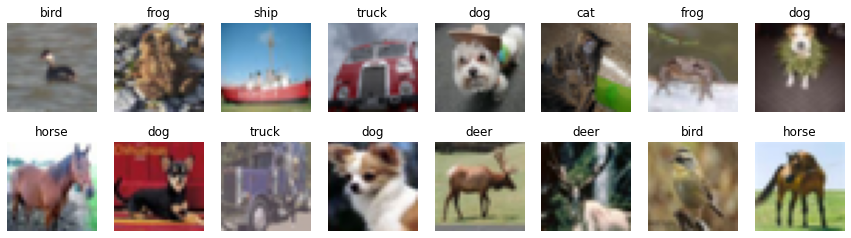

In [6]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Нормализуем картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

Превратим метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [7]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [8]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [9]:
def make_default_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', activation = 'relu', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation = 'relu',))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation = 'relu',))
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation = 'relu',))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='relu'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='softmax'))
    return model

In [10]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

# Тренируем модель

In [11]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [12]:
# учим дефолтную архитектуру
train_model()

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 12s 244us/sample - loss: 1.4811 - accuracy: 0.4639 - val_loss: 1.0795 - val_accuracy: 0.6141
Epoch 2/10
50000/50000 [==============================] - 8s 150us/sample - loss: 1.1021 - accuracy: 0.6095 - val_loss: 0.8774 - val_accuracy: 0.6884
Epoch 3/10
50000/50000 [==============================] - 8s 151us/sample - loss: 0.9349 - accuracy: 0.6708 - val_loss: 0.8049 - val_accuracy: 0.7144
Epoch 4/10
50000/50000 [==============================] - 8s 150us/sample - loss: 0.8425 - accuracy: 0.7029 - val_loss: 0.8219 - val_accuracy: 0.7125
Epoch 5/10
50000/50000 [==============================] - 8s 152us/sample - loss: 0.7803 - accuracy: 0.7247 - val_loss: 0.7312 - val_accuracy: 0.7425
Epoch 6/10
50000/50000 [==============================] - 8s 156us/sample - loss: 0.7342 - accuracy: 0.7430 - val_loss: 0.8064 - val_accuracy: 0.7247
Epoch 7/10
50000/50000 [=========================

In [13]:
def make_sigmoid_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', activation = 'sigmoid', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation = 'sigmoid',))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation = 'sigmoid',))
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation = 'sigmoid',))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='sigmoid'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='softmax'))
    return model

In [14]:
# учим sigmoid
train_model(make_sigmoid_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 167us/sample - loss: 2.3149 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/10
50000/50000 [==============================] - 7s 149us/sample - loss: 2.3036 - accuracy: 0.0968 - val_loss: 2.3085 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 8s 150us/sample - loss: 2.3034 - accuracy: 0.0977 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 4/10
50000/50000 [==============================] - 7s 150us/sample - loss: 2.3037 - accuracy: 0.0965 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 8s 150us/sample - loss: 2.3034 - accuracy: 0.0994 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 7s 150us/sample - loss: 2.3034 - accuracy: 0.0983 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [==========================

In [15]:
# учим sgd
train_model(optimizer="sgd")

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 163us/sample - loss: 2.0545 - accuracy: 0.2488 - val_loss: 1.7181 - val_accuracy: 0.3921
Epoch 2/10
50000/50000 [==============================] - 8s 161us/sample - loss: 1.6758 - accuracy: 0.3876 - val_loss: 1.4902 - val_accuracy: 0.4600
Epoch 3/10
50000/50000 [==============================] - 7s 147us/sample - loss: 1.5067 - accuracy: 0.4533 - val_loss: 1.3709 - val_accuracy: 0.4997
Epoch 4/10
50000/50000 [==============================] - 8s 154us/sample - loss: 1.3819 - accuracy: 0.5016 - val_loss: 1.2700 - val_accuracy: 0.5423
Epoch 5/10
50000/50000 [==============================] - 7s 147us/sample - loss: 1.2927 - accuracy: 0.5371 - val_loss: 1.1683 - val_accuracy: 0.5853
Epoch 6/10
50000/50000 [==============================] - 7s 148us/sample - loss: 1.2154 - accuracy: 0.5659 - val_loss: 1.1363 - val_accuracy: 0.5961
Epoch 7/10
50000/50000 [==========================

In [16]:
def make_bn_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', activation = 'relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation = 'relu',))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation = 'relu',))
    model.add(BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation = 'relu',))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='softmax'))
    return model

In [17]:
# учим bn
train_model(make_bn_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 207us/sample - loss: 1.4660 - accuracy: 0.4935 - val_loss: 1.0519 - val_accuracy: 0.6286
Epoch 2/10
50000/50000 [==============================] - 9s 184us/sample - loss: 1.0105 - accuracy: 0.6422 - val_loss: 0.9409 - val_accuracy: 0.6757
Epoch 3/10
50000/50000 [==============================] - 9s 184us/sample - loss: 0.8884 - accuracy: 0.6883 - val_loss: 0.7643 - val_accuracy: 0.7333
Epoch 4/10
50000/50000 [==============================] - 9s 183us/sample - loss: 0.8039 - accuracy: 0.7171 - val_loss: 0.7802 - val_accuracy: 0.7318
Epoch 5/10
50000/50000 [==============================] - 9s 184us/sample - loss: 0.7333 - accuracy: 0.7450 - val_loss: 0.6838 - val_accuracy: 0.7647
Epoch 6/10
50000/50000 [==============================] - 9s 184us/sample - loss: 0.6765 - accuracy: 0.7615 - val_loss: 0.6724 - val_accuracy: 0.7695
Epoch 7/10
50000/50000 [=========================

In [18]:
def make_sigmoid_bn_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', activation = 'sigmoid', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation = 'sigmoid',))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same', activation = 'sigmoid',))
    model.add(BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same', activation = 'sigmoid',))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='sigmoid'))
    model.add(BatchNormalization())
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='softmax'))
    return model

In [19]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 10s 205us/sample - loss: 1.6034 - accuracy: 0.4317 - val_loss: 1.3813 - val_accuracy: 0.5181
Epoch 2/10
50000/50000 [==============================] - 9s 182us/sample - loss: 1.2029 - accuracy: 0.5752 - val_loss: 1.0758 - val_accuracy: 0.6305
Epoch 3/10
50000/50000 [==============================] - 9s 182us/sample - loss: 1.0766 - accuracy: 0.6225 - val_loss: 0.9046 - val_accuracy: 0.6825
Epoch 4/10
50000/50000 [==============================] - 9s 183us/sample - loss: 0.9944 - accuracy: 0.6529 - val_loss: 0.9833 - val_accuracy: 0.6659
Epoch 5/10
50000/50000 [==============================] - 9s 182us/sample - loss: 0.9329 - accuracy: 0.6744 - val_loss: 0.9048 - val_accuracy: 0.6870
Epoch 6/10
50000/50000 [==============================] - 9s 182us/sample - loss: 0.8836 - accuracy: 0.6926 - val_loss: 0.8434 - val_accuracy: 0.7091
Epoch 7/10
50000/50000 [=========================